In [132]:
import numpy as np
from scipy.optimize import minimize_scalar


<h4> Defining models

In [133]:
def linear_model(x, a, b):
    return a * x + b
def rational_model(x, a, b):
    return a / (1 + b * (x+1e-9))

<h4> Defining the loss function

In [134]:
def loss(f,x, y,a, b):
    return np.sum((f(x, a, b) - y) ** 2)

<h4> The first algorithm Gradient-descent

In [135]:
def my_steep_des(model, x, y, init_a, init_b, trueab, eps2=1e-3, eps=1e-6, maxiter=200):
    def check(nowab, trueab, eps2):
        return np.linalg.norm(nowab - trueab) < eps2

    a1, b1 = init_a, init_b

    d_f_a = (loss(model, x, y, a1 + eps, b1) - loss(model, x, y, a1 - eps, b1)) / (2 * eps)
    d_f_b = (loss(model, x, y, a1, b1 + eps) - loss(model, x, y, a1, b1 - eps)) / (2 * eps)

    res = minimize_scalar(lambda alpha: loss(model, x, y, a1 - alpha * d_f_a, b1 - alpha * d_f_b),
                          bounds=(0, 1), method='bounded')
    first_beta = res.x
    a2 = a1 - first_beta * d_f_a
    b2 = b1 - first_beta * d_f_b

    it = 0
    f_ev=0
    while it < maxiter:
        it += 1
        d_f_a1 = (loss(model, x, y, a1 + eps, b1) - loss(model, x, y, a1 - eps, b1)) / (2 * eps)
        d_f_b1 = (loss(model, x, y, a1, b1 + eps) - loss(model, x, y, a1, b1 - eps)) / (2 * eps)
        d_f_a2 = (loss(model, x, y, a2 + eps, b2) - loss(model, x, y, a2 - eps, b2)) / (2 * eps)
        d_f_b2 = (loss(model, x, y, a2, b2 + eps) - loss(model, x, y, a2, b2 - eps)) / (2 * eps)
        f_ev+=4
        df1 = np.array([d_f_a1, d_f_b1])
        df2 = np.array([d_f_a2, d_f_b2])
        AB1 = np.array([a1, b1])
        AB2 = np.array([a2, b2])

        S = AB2 - AB1
        DF = df2 - df1

        denom = np.dot(DF, DF)
        if denom == 0 or np.isclose(denom, 0.0):
            beta = 0.0
        else:
            beta = abs(np.dot(S, DF)) / denom

        beta = np.clip(beta, 0.0, 1e6)

        AB_next = AB2 - beta * df2

        if not np.isfinite(AB_next).all():
            AB_next = AB2 - 1e-3 * df2
            if not np.isfinite(AB_next).all():
                break

        a1, b1 = a2, b2
        a2, b2 = AB_next[0], AB_next[1]

        if check(np.array([a2, b2]), trueab, eps2):
            break

    return a2, b2, loss(model, x, y, a2, b2), f_ev,it



<h4> The second algorithm Non-linear Conjugate gradient-descent

In [136]:
def gra_des(model, x, y, init_a, init_b,
            eps2=1e-3, flag=1, eps_fd=1e-6, maxiter=200,
            b_bound=1e2, max_step_norm=1.0, restart_tol=1e-12):
    def _eps_for_param(p, base=eps_fd):
        return base * max(1.0, abs(p))

    def analytic_grad_if_available(model_fn, xv, yv, a, b):
        if model_fn is rational_model:
            denom = (1.0 + b * (xv + 1e-9))
            da = 1.0 / denom
            db = -a * (xv + 1e-9) / (denom ** 2)
            r = model_fn(xv, a, b) - yv
            grad_a = 2.0 * np.dot(da, r)
            grad_b = 2.0 * np.dot(db, r)
            return np.array([grad_a, grad_b])
        ha = _eps_for_param(a)
        hb = _eps_for_param(b)
        fa_p = model_fn(xv, a + ha, b)
        fa_m = model_fn(xv, a - ha, b)
        fb_p = model_fn(xv, a, b + hb)
        fb_m = model_fn(xv, a, b - hb)
        Jr_a = (fa_p - fa_m) / (2 * ha)
        Jr_b = (fb_p - fb_m) / (2 * hb)
        r = model_fn(xv, a, b) - yv
        return np.array([2.0 * np.dot(Jr_a, r), 2.0 * np.dot(Jr_b, r)])

    loss_count = 0
    def loss_fn(model_fn, xv, yv, a, b):
        nonlocal loss_count
        try:
            loss_count += 1
            return float(np.sum((model_fn(xv, a, b) - yv) ** 2))
        except Exception:
            loss_count += 1
            return float(np.inf)

    a = float(init_a)
    b = float(init_b)
    b = float(np.clip(b, -b_bound, b_bound))

    grad = analytic_grad_if_available(model, x, y, a, b)
    s = -grad.copy()
    history = []
    it = 0

    while it < maxiter:
        it += 1
        if np.dot(s, grad) >= 0 or not np.isfinite(s).all():
            s = -grad.copy()
        s_norm = np.linalg.norm(s)
        if s_norm > max_step_norm and s_norm > 0:
            s = s * (max_step_norm / s_norm)
            s_norm = np.linalg.norm(s)
        alpha = 1.0
        c = 1e-4
        rho = 0.5
        f0 = loss_fn(model, x, y, a, b)
        grad_dot_s = np.dot(grad, s)
        found = False
        for _ in range(25):
            a_trial = a + alpha * s[0]
            b_trial = float(np.clip(b + alpha * s[1], -b_bound, b_bound))
            f_trial = loss_fn(model, x, y, a_trial, b_trial)
            if np.isfinite(f_trial) and f_trial <= f0 + c * alpha * grad_dot_s:
                found = True
                break
            alpha *= rho
            if alpha * s_norm < 1e-12:
                break
        if not found:
            alpha = min(1.0, 1e-3)
            s = -grad
            a_trial = a + alpha * s[0]
            b_trial = float(np.clip(b + alpha * s[1], -b_bound, b_bound))
            f_trial = loss_fn(model, x, y, a_trial, b_trial)
        step = np.array([a_trial - a, b_trial - b])
        step_norm = np.linalg.norm(step)
        if step_norm > max_step_norm and step_norm > 0:
            step = step * (max_step_norm / step_norm)
            a_trial = a + step[0]
            b_trial = float(np.clip(b + step[1], -b_bound, b_bound))
            f_trial = loss_fn(model, x, y, a_trial, b_trial)
        a_old, b_old = a, b
        a, b = float(a_trial), float(b_trial)
        grad_new = analytic_grad_if_available(model, x, y, a, b)
        denom = np.dot(grad, grad)
        if denom < restart_tol:
            beta = 0.0
        else:
            beta_FR = np.dot(grad_new, grad_new) / denom
            beta_PR = abs(np.dot(grad_new, grad_new - grad) / denom)
            beta = float(np.clip(beta_FR * flag + beta_PR * (1 - flag), -1e6, 1e6))
        s = -grad_new + beta * s
        if np.dot(s, grad_new) >= 0 or not np.isfinite(s).all():
            s = -grad_new.copy()
            beta = 0.0
        history.append({"iter": it, "a": a, "b": b, "loss": f_trial, "grad_norm": float(np.linalg.norm(grad_new)), "beta": float(beta)})
        if np.linalg.norm(np.array([a, b]) - np.array([a_old, b_old])) < eps2:
            break
        if np.linalg.norm(grad_new) < 1e-8:
            break
        if not np.isfinite(a) or not np.isfinite(b):
            break
        grad = grad_new

    final_loss = loss_fn(model, x, y, a, b)
    return a, b, final_loss, loss_count, it


<h4> The third algorithm Newton

In [152]:
def myNewton(model, x, y, init_a, init_b, eps2=1e-6, eps=1e-6, maxiter=100):
    def check(nowab, oldab, tol):
        return np.linalg.norm(nowab - oldab) < tol

    a1 = float(init_a)
    b1 = float(init_b)
    i=0
    f_ev=0
    for it in range(maxiter):
        i+=1
        dfa = (loss(model, x, y, a1 + eps, b1) - loss(model, x, y, a1 - eps, b1)) / (2 * eps)
        dfb = (loss(model, x, y, a1, b1 + eps) - loss(model, x, y, a1, b1 - eps)) / (2 * eps)
        f_ev+=4
        grad = np.array([dfa, dfb])

        ddfa = (loss(model, x, y, a1 + eps, b1) + loss(model, x, y, a1 - eps, b1)
                - 2 * loss(model, x, y, a1, b1)) / (eps * eps)
        ddfb = (loss(model, x, y, a1, b1 + eps) + loss(model, x, y, a1, b1 - eps)
                - 2 * loss(model, x, y, a1, b1)) / (eps * eps)
        f_ev+=1

        ddfab = (
            loss(model, x, y, a1 + eps, b1 + eps)
            - loss(model, x, y, a1 + eps, b1 - eps)
            - loss(model, x, y, a1 - eps, b1 + eps)
            + loss(model, x, y, a1 - eps, b1 - eps)
        ) / (4 * eps * eps)
        f_ev+=4
        H = np.array([[ddfa, ddfab],
                      [ddfab, ddfb]])

        try:
            p = np.linalg.solve(H, grad)
        except np.linalg.LinAlgError:
            step = 1e-3
            a_new = a1 - step * grad[0]
            b_new = b1 - step * grad[1]
            old_ab = np.array([a1, b1])
            a1, b1 = a_new, b_new
            if check(np.array([a1, b1]), old_ab, eps2):
                break
            continue

        old_ab = np.array([a1, b1])
        a1 = a1 - p[0]
        b1 = b1 - p[1]
        if check(np.array([a1, b1]), old_ab, eps2):
            break

    return a1, b1, loss(model, x, y, a1, b1), f_ev,i

<h4> The last algorithm LMV

In [153]:
def lm_fit(model, x, y, init_a, init_b,
           eps_fd=1e-6, tol=1e-6, maxiter=200,
           lambda0=1e-3, lambda_up=10.0, lambda_down=0.1,
           use_analytic_jacobian=False, max_step_norm=1e3, b_bound=1e2):

    def residual(a, b):
        return model(x, a, b) - y

    def jacobian(a, b):
        if use_analytic_jacobian and model is rational_model:
            denom = (1.0 + b * (x + 1e-9))
            Jr_a = 1.0 / denom
            Jr_b = -a * (x + 1e-9) / (denom * denom)
            return np.vstack([Jr_a, Jr_b]).T
        ha = max(eps_fd, 1e-6 * max(1.0, abs(a)))
        hb = max(eps_fd, 1e-6 * max(1.0, abs(b)))
        fa_plus = model(x, a + ha, b)
        fa_minus = model(x, a - ha, b)
        fb_plus = model(x, a, b + hb)
        fb_minus = model(x, a, b - hb)
        Jr_a = (fa_plus - fa_minus) / (2 * ha)
        Jr_b = (fb_plus - fb_minus) / (2 * hb)
        return np.vstack([Jr_a, Jr_b]).T

    a = float(init_a)
    b = float(init_b)
    lam = float(lambda0)

    hist = []
    loss_eval_count = 0

    r = residual(a, b)
    loss_val = 0.5 * np.dot(r, r)
    loss_eval_count += 1

    iter_count = 0
    for it in range(1, maxiter + 1):
        iter_count = it

        J = jacobian(a, b)
        JTJ = J.T @ J
        JTr = J.T @ r

        D = np.diag(np.diag(JTJ))
        A = JTJ + lam * D + 1e-12 * np.eye(JTJ.shape[0])

        try:
            delta = np.linalg.solve(A, -JTr)
        except np.linalg.LinAlgError:
            lam *= lambda_up
            hist.append((it, a, b, loss_val, lam))
            continue

        if np.linalg.norm(delta) > max_step_norm:
            delta = delta * (max_step_norm / np.linalg.norm(delta))

        a_new = float(a + delta[0])
        b_new = float(np.clip(b + delta[1], -b_bound, b_bound))

        r_new = residual(a_new, b_new)
        loss_new = 0.5 * np.dot(r_new, r_new)
        loss_eval_count += 1

        if loss_new < loss_val:
            a, b, r, loss_val = a_new, b_new, r_new, loss_new
            lam = max(lam * lambda_down, 1e-16)
        else:
            lam = lam * lambda_up

        hist.append((it, a, b, loss_val, lam))

        if np.linalg.norm(delta) < tol:
            break
        if abs(loss_new - loss_val) < tol:
            break

    return a, b, loss_val, loss_eval_count,iter_count


In [154]:
np.random.seed(23)
alpha = np.random.rand()
beta = np.random.rand()
k = np.arange(101)
x = k / 100
delta = np.random.normal(0, 1, size=len(x))
y = alpha * x + beta + delta*1
trueab=np.array([alpha,beta])



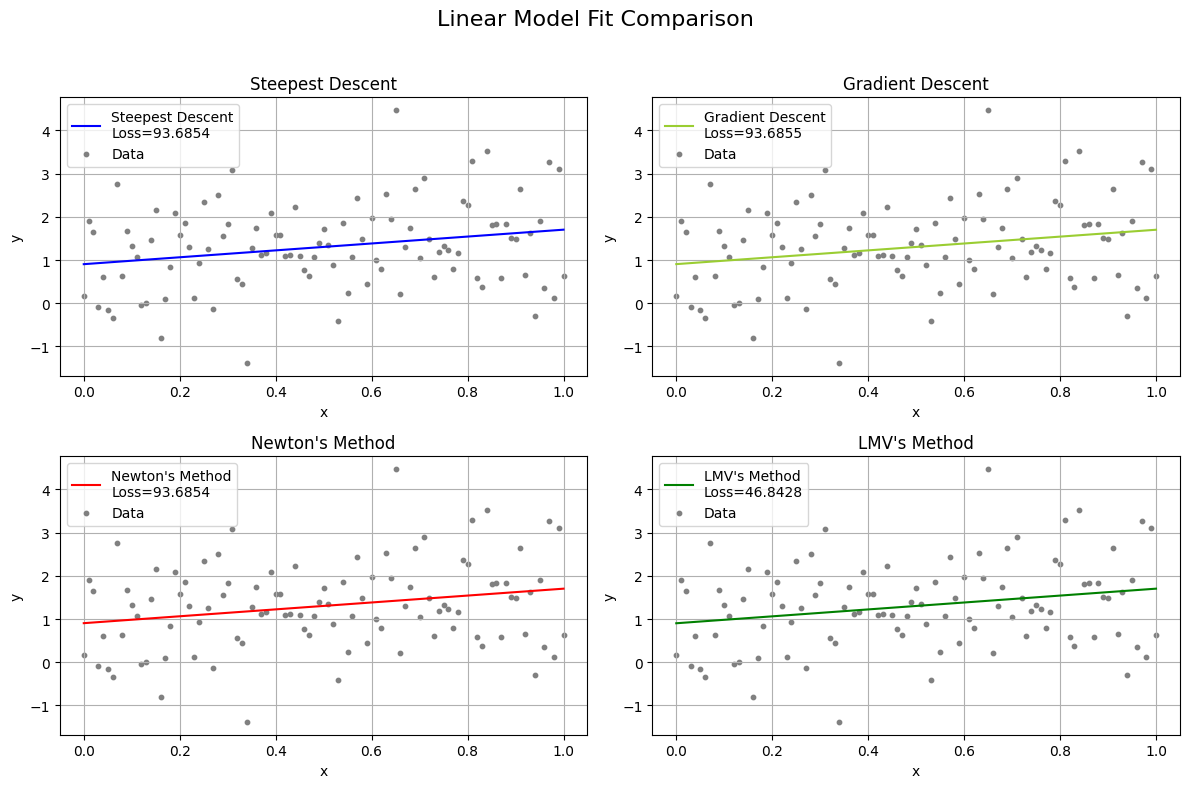


 Optimization Summary:

Algorithm            Iterations   Func Evals   Final Loss   a          b         
--------------------------------------------------------------------------------
Steepest Descent     200          800          93.685388    0.7979     0.9043    
Gradient Descent     19           131          93.685462    0.7952     0.9053    
Newton's Method      4            36           93.685388    0.7979     0.9043    
LMV's Method         1            2            46.842755    0.8000     0.9023    


In [155]:
import matplotlib.pyplot as plt
model=linear_model
init_a =0
init_b=0
a_sd, b_sd, loss_sd, fev_sd, it_sd = my_steep_des(model, x, y, init_a, init_b, trueab)
a_gd, b_gd, loss_gd, fev_gd, it_gd = gra_des(model, x, y, init_a, init_b)
a_nt, b_nt, loss_nt, fev_nt, it_nt = myNewton(model, x, y, init_a, init_b)
a_lm, b_lm, loss_lm, fev_lm, it_lm = lm_fit(model, x, y, init_a, init_b)

y_sd = model(x, a_sd, b_sd)
y_gd = model(x, a_gd, b_gd)
y_nt = model(x, a_nt, b_nt)
y_lm = model(x, a_lm, b_lm)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Linear Model Fit Comparison', fontsize=16)

axs[0, 0].plot(x, y_sd, color='blue', label=f'Steepest Descent\nLoss={loss_sd:.4f}')
axs[0, 0].scatter(x, y, color='gray', s=10, label='Data')
axs[0, 0].set_title('Steepest Descent')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(x, y_gd, color='yellowgreen', label=f'Gradient Descent\nLoss={loss_gd:.4f}')
axs[0, 1].scatter(x, y, color='gray', s=10, label='Data')
axs[0, 1].set_title('Gradient Descent')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(x, y_nt, color='red', label=f'Newton\'s Method\nLoss={loss_nt:.4f}')
axs[1, 0].scatter(x, y, color='gray', s=10, label='Data')
axs[1, 0].set_title('Newton\'s Method')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(x, y_lm, color='green', label=f'LMV\'s Method\nLoss={loss_lm:.4f}')
axs[1, 1].scatter(x, y, color='gray', s=10, label='Data')
axs[1, 1].set_title('LMV\'s Method')
axs[1, 1].legend()
axs[1, 1].grid(True)

for ax in axs.flat:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


print("\n Optimization Summary:\n")
print(f"{'Algorithm':<20} {'Iterations':<12} {'Func Evals':<12} {'Final Loss':<12} {'a':<10} {'b':<10}")
print("-" * 80)
print(f"{'Steepest Descent':<20} {it_sd:<12} {fev_sd:<12} {loss_sd:<12.6f} {a_sd:<10.4f} {b_sd:<10.4f}")
print(f"{'Gradient Descent':<20} {it_gd:<12} {fev_gd:<12} {loss_gd:<12.6f} {a_gd:<10.4f} {b_gd:<10.4f}")
print(f"{'Newton\'s Method':<20} {it_nt:<12} {fev_nt:<12} {loss_nt:<12.6f} {a_nt:<10.4f} {b_nt:<10.4f}")
print(f"{'LMV\'s Method':<20} {it_lm:<12} {fev_lm:<12} {loss_lm:<12.6f} {a_lm:<10.4f} {b_lm:<10.4f}")


<h2> <center> Analysing results

<h3> 1- steepst descent is the slowest, i.e takes the most number of iterations and function evaluations to       converge.


2- gradient descent is faster than steepest descent but still slower than newton and lmv.

3- newton and lmv is fastest, it takes the least number of iterations and function evaluations to converge, and the accurcy it achievs is amazing.

4- lmv combines the advantages of both gradient descent and newton, it is more robust than newton and faster than gradient descent.

<h3><center> Now Experimenting with rational model


<h5> Hello professor Antony! as you well see at the end of the code, I have visualized the local minima-s of the loss function for the rational model. This visualization helps to understand  how choosing the initial values would be very sensitive, and might lead to missin the global minima. The contour plot highlights areas of low loss, and the detected local minima are marked, providing insights into potential challenges in finding the global minimum.

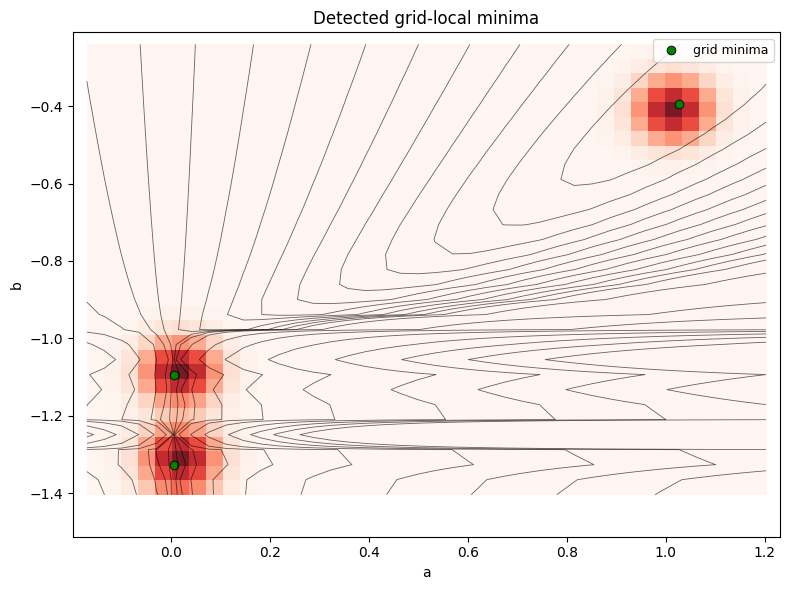

Grid size: 120 x 120 = 14400
Discrete local minima detected on grid: 3
Lowest few minima (a,b,loss):
 1: a=1.02682, b=-0.395497, loss=94.3597
 2: a=0.00536495, b=-1.09388, loss=263.973
 3: a=0.00536495, b=-1.32667, loss=270.209


In [156]:
from scipy.ndimage import minimum_filter, gaussian_filter

model_var = rational_model

def loss_val_vec(model, x, y, a_array, b_scalar):
    a_col = a_array[:, None]
    xv = x[None, :]  # (1,nx)
    if model is rational_model:
        denom = (1.0 + b_scalar * (xv + 1e-9))
        F = a_col / denom
    else:
        F = a_col * xv + b_scalar
    R = F - y[None, :]
    return np.sum(R * R, axis=1)


A = np.vstack([x, np.ones_like(x)]).T
a_lin, b_lin = np.linalg.lstsq(A, y, rcond=None)[0]
center_a, center_b = float(a_lin), float(b_lin)

na, nb = 120, 120
da = max(0.5, 2.0 * abs(center_a) + 0.5)
db = max(0.5, 2.0 * abs(center_b) + 0.5)
a_vals = np.linspace(center_a - da, center_a + da, na)
b_vals = np.linspace(center_b - db, center_b + db, nb)

Z = np.empty((nb, na), dtype=float)
for ib, bval in enumerate(b_vals):
    Z[ib, :] = loss_val_vec(model_var, x, y, a_vals, bval)


Z_min = minimum_filter(Z, size=3, mode='reflect')
is_local_min = (Z == Z_min)
# clear borders to avoid edge artifacts
is_local_min[0, :] = False
is_local_min[-1, :] = False
is_local_min[:, 0] = False
is_local_min[:, -1] = False

min_indices = np.argwhere(is_local_min)
min_list = [(ia, ib, a_vals[ia], b_vals[ib], float(Z[ib, ia])) for ib, ia in min_indices]
min_list.sort(key=lambda t: t[4])


mask = np.zeros_like(Z, dtype=float)
for ia, ib, _, _, _ in min_list:
    mask[ib, ia] = 1.0
density = gaussian_filter(mask, sigma=1.5)


if len(min_list) > 0:
    mins_a = np.array([m[2] for m in min_list])
    mins_b = np.array([m[3] for m in min_list])
    margin_a = max(1e-3, 0.2 * (np.ptp(mins_a) if np.ptp(mins_a) > 0 else da))
    margin_b = max(1e-3, 0.2 * (np.ptp(mins_b) if np.ptp(mins_b) > 0 else db))
    crop_a_min = mins_a.min() - margin_a
    crop_a_max = mins_a.max() + margin_a
    crop_b_min = mins_b.min() - margin_b
    crop_b_max = mins_b.max() + margin_b
else:
    crop_a_min, crop_a_max = a_vals[0], a_vals[-1]
    crop_b_min, crop_b_max = b_vals[0], b_vals[-1]

mask_a = (a_vals >= crop_a_min) & (a_vals <= crop_a_max)
mask_b = (b_vals >= crop_b_min) & (b_vals <= crop_b_max)
Z_crop = Z[np.ix_(mask_b, mask_a)]
density_crop = density[np.ix_(mask_b, mask_a)]


fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.imshow(density_crop, origin='lower',
          extent=(a_vals[mask_a].min(), a_vals[mask_a].max(), b_vals[mask_b].min(), b_vals[mask_b].max()),
          cmap='Reds', alpha=0.9, aspect='auto')


levels = np.percentile(Z_crop, np.linspace(5, 95, 20))
cf = ax.contour(a_vals[mask_a], b_vals[mask_b], Z_crop, levels=levels, colors='k', linewidths=0.6, alpha=0.6)


if len(min_list) > 0:
    mins_plot = np.array([[m[2], m[3]] for m in min_list])
    in_crop = (mins_plot[:, 0] >= crop_a_min) & (mins_plot[:, 0] <= crop_a_max) & \
              (mins_plot[:, 1] >= crop_b_min) & (mins_plot[:, 1] <= crop_b_max)
    ax.scatter(mins_plot[in_crop, 0], mins_plot[in_crop, 1], c='green', s=40, edgecolor='black', linewidth=0.6,
               label='grid minima')

ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_title('Detected grid-local minima')
ax.set_xlim(crop_a_min, crop_a_max)
ax.set_ylim(crop_b_min, crop_b_max)
ax.legend(fontsize=9, loc='upper right')
plt.tight_layout()
plt.show()

print(f"Grid size: {na} x {nb} = {na * nb}")
print(f"Discrete local minima detected on grid: {len(min_list)}")
print("Lowest few minima (a,b,loss):")
for i, m in enumerate(min_list[:12]):
    print(f"{i + 1:2d}: a={m[2]:.6g}, b={m[3]:.6g}, loss={m[4]:.6g}")


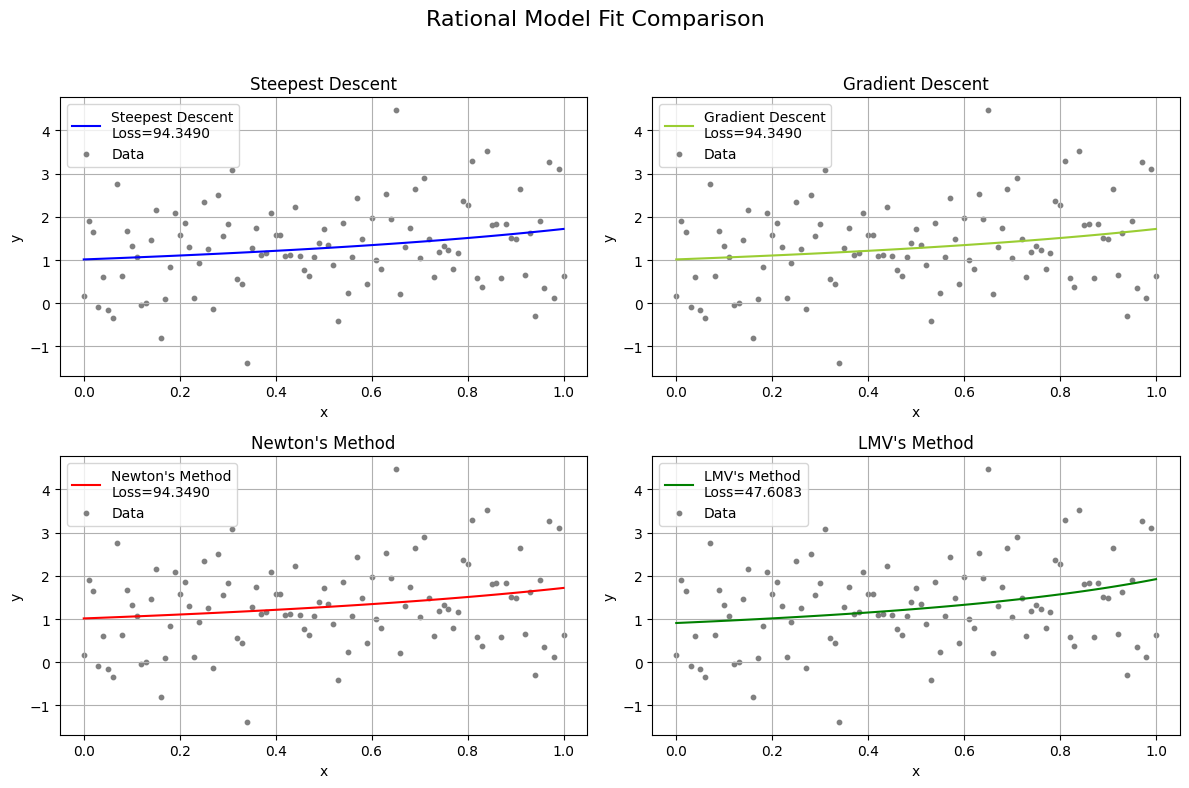


 Optimization Summary:

Algorithm            Iterations   Func Evals   Final Loss   a          b         
--------------------------------------------------------------------------------
Steepest Descent     200          800          94.348959    1.0140     -0.4102   
Gradient Descent     21           138          94.348964    1.0143     -0.4100   
Newton's Method      8            72           94.348959    1.0140     -0.4102   
LMV's Method         1            2            47.608315    0.9082     -0.5275   


In [159]:
model = rational_model
init_a=1.5
init_b=0
a_sd, b_sd, loss_sd, fev_sd, it_sd = my_steep_des(model, x, y, init_a, init_b, trueab)
a_gd, b_gd, loss_gd, fev_gd, it_gd = gra_des(model, x, y, init_a, init_b)
a_nt, b_nt, loss_nt, fev_nt, it_nt = myNewton(model, x, y, init_a, init_b)
a_lm, b_lm, loss_lm, fev_lm, it_lm = lm_fit(model, x, y, init_a, init_b)

y_sd = model(x, a_sd, b_sd)
y_gd = model(x, a_gd, b_gd)
y_nt = model(x, a_nt, b_nt)
y_lm = model(x, a_lm, b_lm)


fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Rational Model Fit Comparison', fontsize=16)

axs[0, 0].plot(x, y_sd, color='blue', label=f'Steepest Descent\nLoss={loss_sd:.4f}')
axs[0, 0].scatter(x, y, color='gray', s=10, label='Data')
axs[0, 0].set_title('Steepest Descent')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(x, y_gd, color='yellowgreen', label=f'Gradient Descent\nLoss={loss_gd:.4f}')
axs[0, 1].scatter(x, y, color='gray', s=10, label='Data')
axs[0, 1].set_title('Gradient Descent')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(x, y_nt, color='red', label=f'Newton\'s Method\nLoss={loss_nt:.4f}')
axs[1, 0].scatter(x, y, color='gray', s=10, label='Data')
axs[1, 0].set_title('Newton\'s Method')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(x, y_lm, color='green', label=f'LMV\'s Method\nLoss={loss_lm:.4f}')
axs[1, 1].scatter(x, y, color='gray', s=10, label='Data')
axs[1, 1].set_title('LMV\'s Method')
axs[1, 1].legend()
axs[1, 1].grid(True)

for ax in axs.flat:
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



print("\n Optimization Summary:\n")
print(f"{'Algorithm':<20} {'Iterations':<12} {'Func Evals':<12} {'Final Loss':<12} {'a':<10} {'b':<10}")
print("-" * 80)
print(f"{'Steepest Descent':<20} {it_sd:<12} {fev_sd:<12} {loss_sd:<12.6f} {a_sd:<10.4f} {b_sd:<10.4f}")
print(f"{'Gradient Descent':<20} {it_gd:<12} {fev_gd:<12} {loss_gd:<12.6f} {a_gd:<10.4f} {b_gd:<10.4f}")
print(f"{'Newton\'s Method':<20} {it_nt:<12} {fev_nt:<12} {loss_nt:<12.6f} {a_nt:<10.4f} {b_nt:<10.4f}")
print(f"{'LMV\'s Method':<20} {it_lm:<12} {fev_lm:<12} {loss_lm:<12.6f} {a_lm:<10.4f} {b_lm:<10.4f}")


<h4> General observations about the performance of the algorithms on the rational model compared to the linear model:

   - If we change the initial values, the results will change a lot, and might lead to missing the global minima.
   - The rational model is more complex and non-linear, which can lead to a more challenging optimization landscape with multiple local minima.
   - The final loss values may also be higher for the rational model, which makes sense due to the incompatibility between the model and the original model which the samples are derivative from.
   - The sensitivity to initial conditions is more pronounced in the rational model, **making it crucial to choose starting points carefully.**